In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
def plot(dataset):
    datasize = pd.read_csv('../training_data/' + dataset + '/target.csv').shape[0]

    # Load the CSV data
    data = pd.read_csv('../acc_rate_csvs/' + dataset + '.csv')

    # Plotting
    plt.figure(figsize=(8, 4))

    # Plot methods
    for _, row in data.iterrows():
        color = 'red' if row['method'].startswith(('mlp', 'rnn')) else 'black'
        plt.errorbar(row['acc'], row['method'], fmt='o', color=color, capsize=5, capthick=2, elinewidth=2)

    # Add grid
    plt.grid(True, which='both', linestyle='--', linewidth=0.7)

    # Add labels and title
    plt.ylabel('Method')
    plt.xlabel('Accuracy')
    plt.title('Accuracy of each method: ' + dataset + f" (N = {datasize})")

    # Close the plot to free memory
    plt.show()

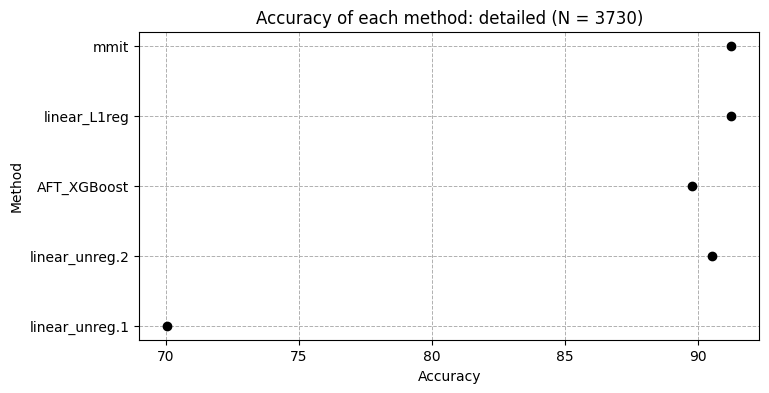

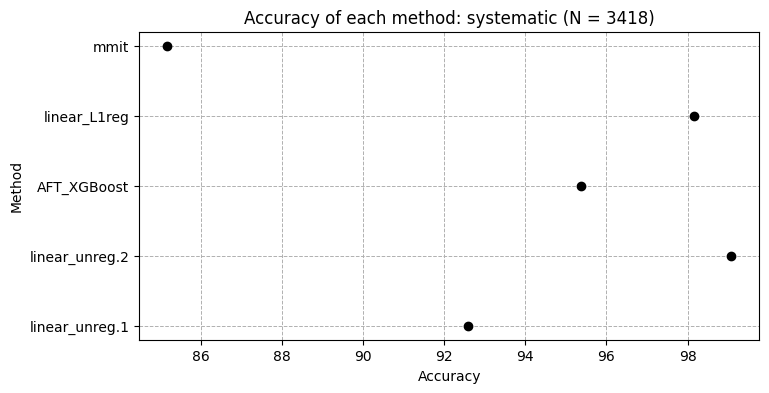

In [3]:
for dataset in ['detailed', 'systematic']:
    plot(dataset)